This project uses the RAVDESS dataset which contains emotional speech of different expressions with over a thousand files

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings

In [2]:
Ravdess = 'audio_speech_actors_01-24/'

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)

df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
df.head()


,Emotions,Path
0,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
1,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
2,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
3,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
4,calm,audio_speech_actors_01-24/Actor_01/03-01-02-01...


In [4]:
print(df)

      Emotions                                               Path
0      neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
1      neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
2      neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
3      neutral  audio_speech_actors_01-24/Actor_01/03-01-01-01...
4         calm  audio_speech_actors_01-24/Actor_01/03-01-02-01...
...        ...                                                ...
1435  surprise  audio_speech_actors_01-24/Actor_24/03-01-08-01...
1436  surprise  audio_speech_actors_01-24/Actor_24/03-01-08-02...
1437  surprise  audio_speech_actors_01-24/Actor_24/03-01-08-02...
1438  surprise  audio_speech_actors_01-24/Actor_24/03-01-08-02...
1439  surprise  audio_speech_actors_01-24/Actor_24/03-01-08-02...

[1440 rows x 2 columns]


In [5]:
df['Emotions'].value_counts()

Emotions
calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
neutral      96
Name: count, dtype: int64

In [6]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

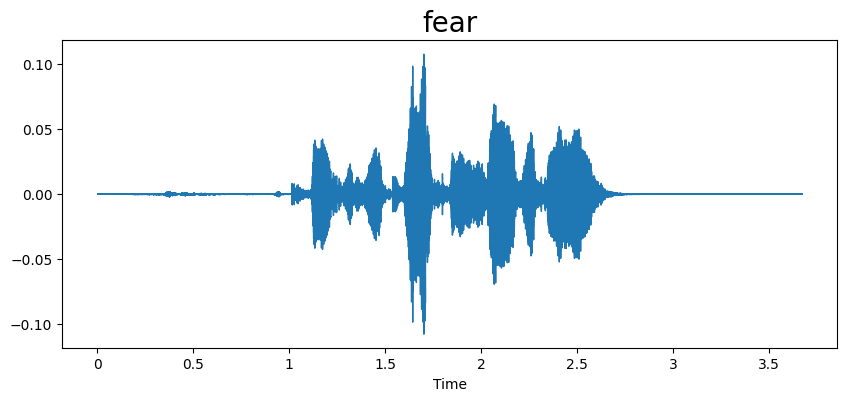

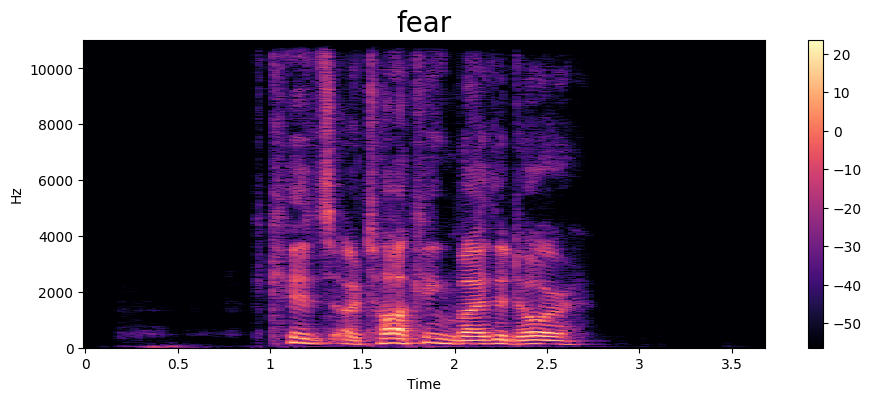

In [7]:
emotion = 'fear'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

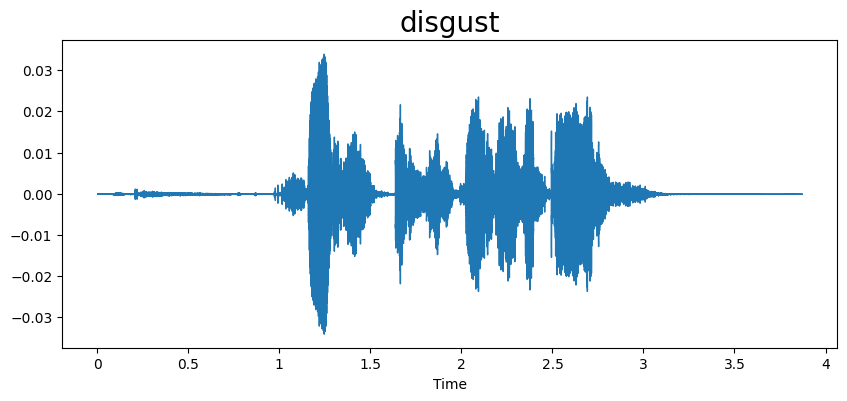

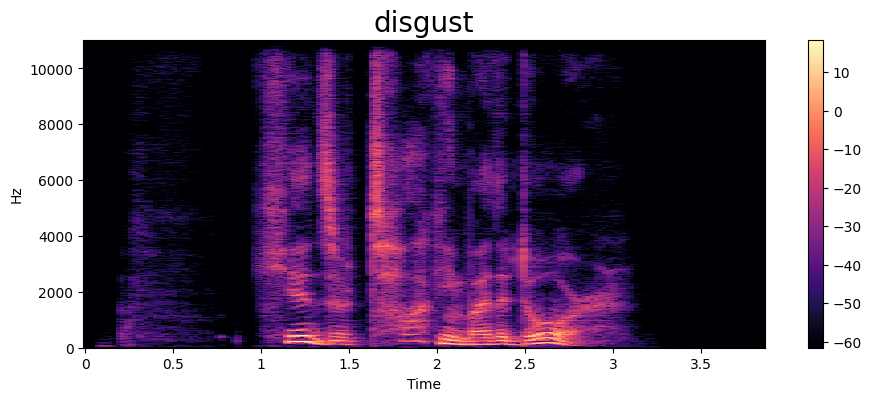

In [8]:
emotion = 'disgust'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [9]:
data_path = pd.concat([df], axis = 0)

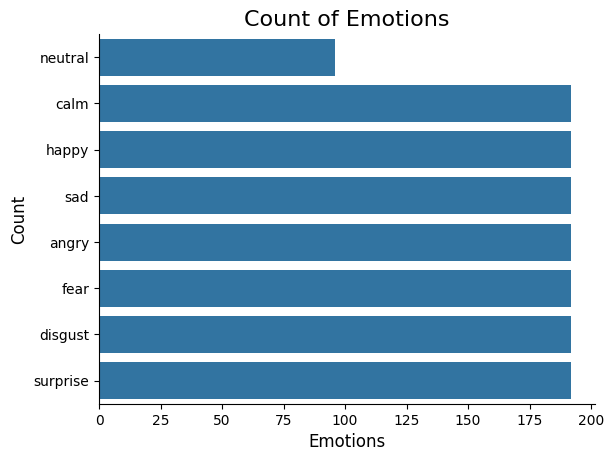

In [10]:

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

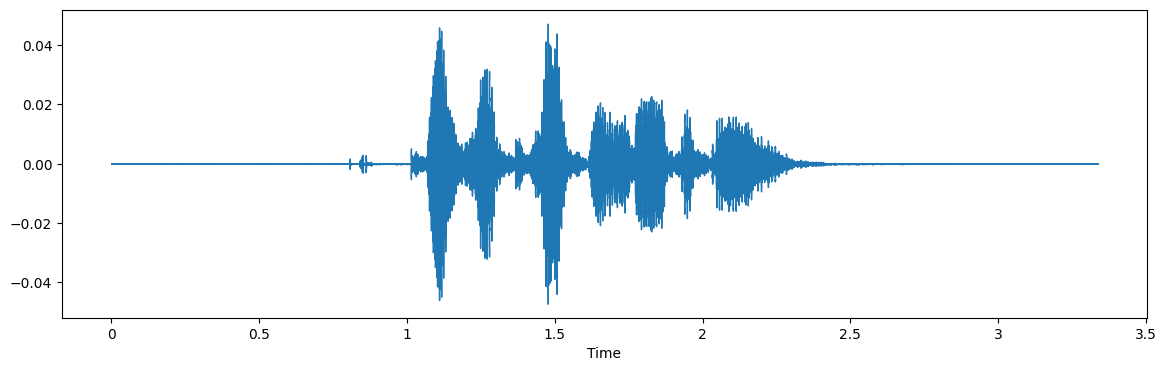

In [12]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

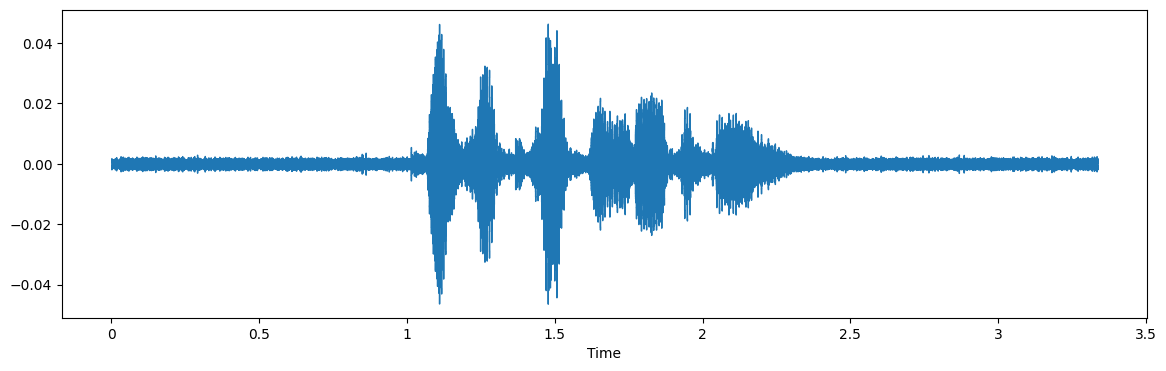

In [13]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [14]:
# x = stretch(data)
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

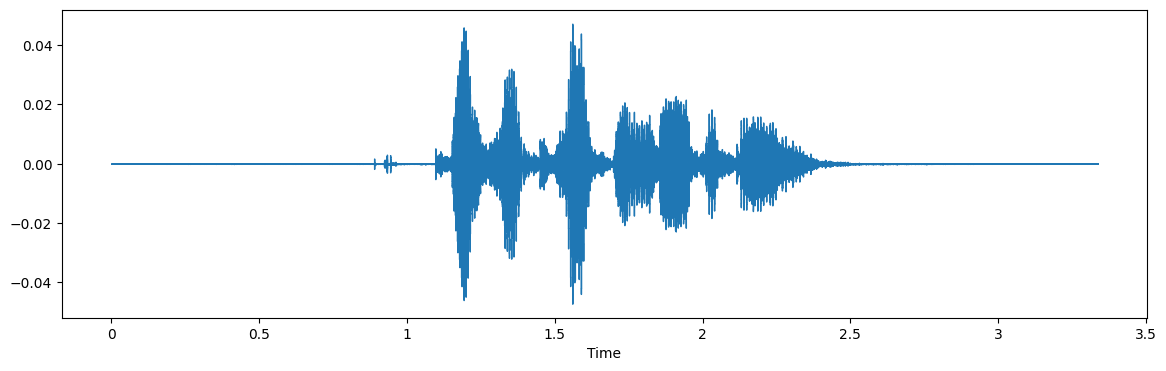

In [15]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [16]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result
    
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
  
    return result

In [17]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [18]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,0.000004,0.000003,0.000002,0.000002,0.000005,0.000008,0.000007,0.000005,4.245834e-07,neutral
1,0.318956,0.759421,0.823673,0.817636,0.805919,0.818002,0.732357,0.661363,0.704058,0.740013,...,0.000068,0.000065,0.000066,0.000065,0.000068,0.000069,0.000071,0.000067,6.113406e-05,neutral
2,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,0.000007,0.000007,0.000007,0.000007,0.000012,0.000010,0.000011,0.000006,4.254087e-07,neutral
3,0.324038,0.780523,0.821153,0.815677,0.786954,0.790481,0.752573,0.653225,0.697361,0.730053,...,0.000096,0.000101,0.000101,0.000099,0.000107,0.000105,0.000104,0.000099,9.033601e-05,neutral
4,0.337678,0.715208,0.759374,0.755704,0.757634,0.743580,0.651788,0.629598,0.679255,0.737464,...,0.000013,0.000013,0.000015,0.000020,0.000028,0.000048,0.000032,0.000018,1.461863e-06,neutral


In [19]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [20]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162), (2160, 8), (720, 162), (720, 8))

In [22]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162), (2160, 8), (720, 162), (720, 8))

In [23]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162, 1), (2160, 8), (720, 162, 1), (720, 8))

In [24]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)         

In [25]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


34/34 [==============================] - 4s 77ms/step - loss: 1.9599 - accuracy: 0.2102 - val_loss: 1.9115 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 2s 72ms/step - loss: 1.8908 - accuracy: 0.2435 - val_loss: 1.8754 - val_accuracy: 0.2847 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 2s 72ms/step - loss: 1.8561 - accuracy: 0.2736 - val_loss: 1.8732 - val_accuracy: 0.2361 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 2s 69ms/step - loss: 1.8136 - accuracy: 0.2940 - val_loss: 1.7729 - val_accuracy: 0.3069 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 3s 84ms/step - loss: 1.7560 - accuracy: 0.3009 - val_loss: 1.7254 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 3s 78ms/step - loss: 1.7184 - accuracy: 0.3190 - val_loss: 1.6762 - val_accuracy: 0.3722 - lr: 0.0010
Epoch 7/50
34/34 [==============================] - 3s 79ms/step - loss: 1

23/23 [==============================] - 0s 12ms/step - loss: 1.8329 - accuracy: 0.5917
Accuracy of our model on test data :  59.16666388511658 %


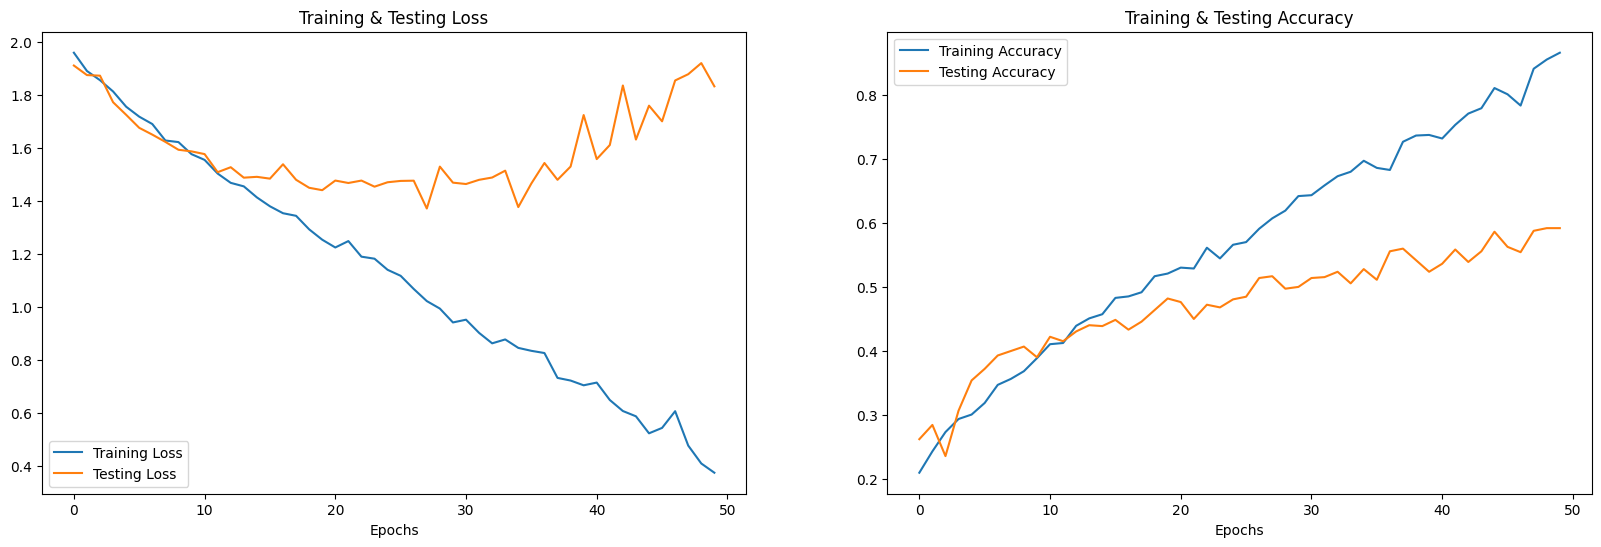

In [26]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [27]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

23/23 [==============================] - 1s 12ms/step


In [28]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,disgust
1,disgust,disgust
2,calm,calm
3,calm,calm
4,neutral,neutral
5,angry,calm
6,surprise,sad
7,calm,calm
8,calm,neutral
9,disgust,disgust


In [29]:
file_path = 'Recording (2).m4a'
new_data, new_sampling_rate = librosa.load(file_path)
new_features = get_features(file_path)
new_features = scaler.transform(new_features)
new_features = np.expand_dims(new_features, axis=2)
new_predictions = model.predict(new_features)
new_predicted_emotion = encoder.inverse_transform(new_predictions)[0][0]
print("Predicted Emotion:", new_predicted_emotion)

C:\Users\phili\AppData\Local\Temp\ipykernel_16024\537793900.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  new_data, new_sampling_rate = librosa.load(file_path)
c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\phili\AppData\Local\Temp\ipykernel_16024\3495498032.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


1/1 [==============================] - 0s 33ms/step
Predicted Emotion: surprise


In [30]:
file_path = 'Recording (3).m4a'
new_data, new_sampling_rate = librosa.load(file_path)
new_features = get_features(file_path)
new_features = scaler.transform(new_features)
new_features = np.expand_dims(new_features, axis=2)
new_predictions = model.predict(new_features)
new_predicted_emotion = encoder.inverse_transform(new_predictions)[0][0]
print("Predicted Emotion:", new_predicted_emotion)

C:\Users\phili\AppData\Local\Temp\ipykernel_16024\1525587142.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  new_data, new_sampling_rate = librosa.load(file_path)
c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\phili\AppData\Local\Temp\ipykernel_16024\3495498032.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


1/1 [==============================] - 0s 32ms/step
Predicted Emotion: angry


In [31]:
file_path = 'Recording.m4a'
new_data, new_sampling_rate = librosa.load(file_path)
new_features = get_features(file_path)
new_features = scaler.transform(new_features)
new_features = np.expand_dims(new_features, axis=2)
new_predictions = model.predict(new_features)
new_predicted_emotion = encoder.inverse_transform(new_predictions)[0][0]
print("Predicted Emotion:", new_predicted_emotion)

C:\Users\phili\AppData\Local\Temp\ipykernel_16024\1891698523.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  new_data, new_sampling_rate = librosa.load(file_path)
c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\phili\AppData\Local\Temp\ipykernel_16024\3495498032.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


1/1 [==============================] - 0s 27ms/step
Predicted Emotion: fear
